# Índice:

- Parte 1) Carga De Datos
- Parte 2) Análisis Exploratorio de Datos (EDA)
- Parte 3) Preprocesamiento de datos
- Parte 4) Train / Test Split y escalado
- Parte 5) Entrenamiento del modelo
- Parte 6) Evaluación del modelo
- Parte 7) Análisis de errores

# Parte 1: Carga de Datos

En esta sección importamos las librerías necesarias para nuestro análisis: pandas y numpy para manipulación de datos, seaborn y matplotlib para visualización, y sklearn para el modelado predictivo y preprocesamiento. También configuramos la conexión con Google Drive para acceder a nuestro dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/csv Corregido/

/content/drive/MyDrive/csv Corregido


In [4]:
ls

model.pkl  scaler.pkl  Telco_Churn.csv


In [5]:
pwd

'/content/drive/MyDrive/csv Corregido'

Datos Del CSV

El dataset contiene información de clientes de telecomunicaciones con 21 columnas que incluyen datos demográficos (gender, SeniorCitizen, Partner, Dependents), información del servicio (tenure, PhoneService, InternetService, etc.), datos financieros (MonthlyCharges, TotalCharges) y la variable objetivo Churn que indica si el cliente abandonó o no el servicio.

In [6]:
df = pd.read_csv("Telco_Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Parte 2: Análisis Exploratorio de Datos (EDA)

Observamos que aproximadamente el 26.5% de los clientes abandonan el servicio, mientras que el 73.5% permanecen. Este desbalance de clases es común en problemas de churn y deberemos tenerlo en cuenta al evaluar nuestro modelo.

In [7]:
df['Churn'].value_counts(normalize=True)


,proportion
Churn,
No,0.73463
Yes,0.26537


Antigüedad (tenure) vs Churn

El gráfico de caja (boxplot) muestra claramente que los clientes que abandonan (Churn=Yes) tienen una mediana de antigüedad significativamente menor. Esto sugiere que la retención mejora con el tiempo, posiblemente debido a mayor satisfacción o costos de cambio más altos.

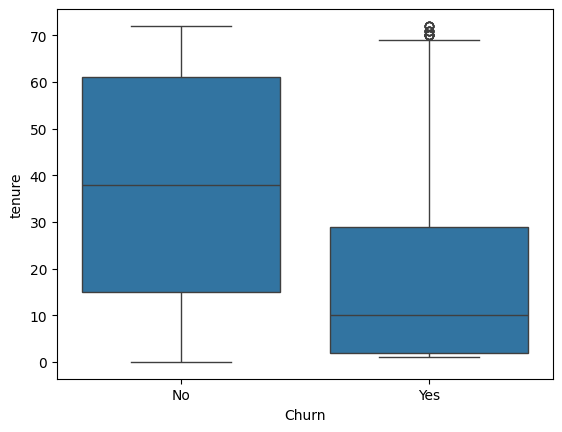

In [8]:
sns.boxplot(x='Churn', y='tenure', data=df)
plt.show()


Tipo de contrato vs Churn

Este gráfico revela un patrón crítico: los contratos mes a mes tienen tasas de abandono mucho más altas que los contratos anuales o bianuales. Esto indica que el compromiso a largo plazo es un factor protector importante contra el churn.

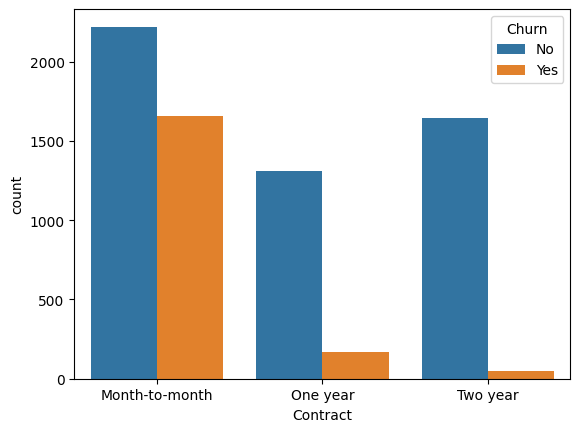

In [9]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.show()

# Parte 3: Preprocesamiento de datos

El preprocesamiento es crucial para preparar los datos para el modelo. Convertimos TotalCharges a numérico y eliminamos valores faltantes, eliminamos el customerID ya que es solo un identificador sin valor predictivo, convertimos Churn a formato binario (1=Yes, 0=No) y aplicamos one-hot encoding a las variables categóricas, eliminando una categoría de referencia para evitar multicolinealidad.

In [10]:
# Limpieza de TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

# Eliminamos identificador
df = df.drop('customerID', axis=1)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df = pd.get_dummies(df, drop_first=True)


# Parte 4: Train / Test Split y escalado

Dividimos los datos en conjuntos de entrenamiento (80%) y prueba (20%) para evaluar el rendimiento del modelo en datos no vistos. La estandarización es necesaria porque la regresión logística es sensible a la escala de las variables, especialmente cuando usamos regularización.

In [11]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Parte 5: Entrenamiento del modelo

Utilizamos Regresión Logística, un modelo lineal apropiado para clasificación binaria. Aumentamos max_iter a 1000 para asegurar la convergencia del algoritmo de optimización. Este modelo nos permitirá interpretar fácilmente qué factores influyen más en el churn.

In [12]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

# Parte 6: Evaluación del modelo

Evaluamos el modelo usando múltiples métricas: Accuracy (proporción total de predicciones correctas), matriz de confusión (muestra verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos) y classification report (incluye precision, recall y f1-score para cada clase).

In [13]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7874911158493249
[[915 118]
 [181 193]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



Interpretación de la matriz de confusión:
- 915 clientes correctamente identificados como No-Churn (verdaderos negativos)
- 193 clientes correctamente identificados como Churn (verdaderos positivos)
- 118 falsos positivos (predijimos churn pero no ocurrió)
- 181 falsos negativos (no predijimos churn pero sí ocurrió)

El recall para la clase Churn (0.52) indica que detectamos aproximadamente la mitad de los casos de abandono.

# Parte 7: Análisis de errores

El modelo falla principalmente en:

- Clientes con características intermedias
- Casos donde las variables disponibles no reflejan la satisfacción real del cliente

Esto sugiere que factores externos como calidad del servicio o atención al cliente podrían mejorar el modelo.

Para mejorar el modelo en futuras iteraciones, podríamos considerar:

1. Incorporar datos sobre interacciones con servicio al cliente
2. Información sobre quejas o reclamaciones
3. Historial de pagos y facturas
4. Uso real de los servicios contratados
5. Aplicar técnicas de balanceo de clases (SMOTE, undersampling, etc.)
6. Probar modelos más complejos como Random Forest o XGBoost